# Descripción del proyecto

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

# Cargar, revisar y preparar los datos 

In [28]:
# Importar librerias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [2]:
# Carga de los datos
data = pd.read_csv('/datasets/Churn.csv')
# Informacion general 
data.info()
# Revisar duplicados y valores ausentes
print(data.isna().sum())
print(data.duplicated().sum())
# mostrar parte del datframe
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Ge

In [3]:
# Rellenar valores ausentes
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median()).astype('int64')

In [4]:
# Creamos variables dummies 
data_ohe = (pd.get_dummies(data.drop('Surname', axis=1),drop_first=True))
print(data_ohe)

      RowNumber  CustomerId  CreditScore  Age  Tenure    Balance  \
0             1    15634602          619   42       2       0.00   
1             2    15647311          608   41       1   83807.86   
2             3    15619304          502   42       8  159660.80   
3             4    15701354          699   39       1       0.00   
4             5    15737888          850   43       2  125510.82   
...         ...         ...          ...  ...     ...        ...   
9995       9996    15606229          771   39       5       0.00   
9996       9997    15569892          516   35      10   57369.61   
9997       9998    15584532          709   36       7       0.00   
9998       9999    15682355          772   42       3   75075.31   
9999      10000    15628319          792   28       5  130142.79   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0                 1          1               1        101348.88       1   
1                 1          0   

In [5]:
# Escalado de variables 
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure']
scaler = StandardScaler()
scaler.fit(data_ohe[numeric])
data_ohe[numeric] = scaler.transform(data_ohe[numeric])
data_ohe[numeric] = scaler.transform(data_ohe[numeric])
# Resetear los índices de los DataFrames
data_ohe.reset_index(drop=True, inplace=True)
data_ohe.reset_index(drop=True, inplace=True)
# Eliminar coummnas innecesarias para el entreno del modelo
data_ohe = data_ohe.drop(['RowNumber', 'CustomerId'], axis=1)
# Convertir booleanos a enteros
data_ohe['Geography_Germany'] = data_ohe['Geography_Germany'].astype(int)
data_ohe['Geography_Spain'] = data_ohe['Geography_Spain'].astype(int)
data_ohe['Gender_Male'] = data_ohe['Gender_Male'].astype(int)

print(data_ohe)

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0       -6.734251 -3.683345 -2.204503 -1.225867      -4.198207          1   
1       -6.735429 -3.692438 -2.335790 -1.225846      -4.198207          0   
2       -6.746776 -3.683345 -1.416780 -1.225826       1.713916          1   
3       -6.725686 -3.710622 -2.335790 -1.225867      -1.242146          0   
4       -6.709521 -3.674253 -2.204503 -1.225835      -4.198207          1   
...           ...       ...       ...       ...            ...        ...   
9995    -6.717978 -3.710622 -1.810641 -1.225867      -1.242146          1   
9996    -6.745278 -3.746992 -1.154206 -1.225853      -4.198207          1   
9997    -6.724616 -3.737899 -1.548067 -1.225867      -4.198207          0   
9998    -6.717871 -3.683345 -2.073216 -1.225848      -1.242146          1   
9999    -6.715730 -3.810638 -1.810641 -1.225834      -4.198207          1   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0      

In [6]:
# Primero, dividimos el dataset en entrenamiento y prueba
data_train_valid, data_test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
# Luego, dividimos el conjunto de entrenamiento en entrenamiento y validación
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345)
# Verificamos los tamaños de cada conjunto
print("Tamaño del conjunto de entrenamiento:", data_train.shape)
print("Tamaño del conjunto de validación:", data_valid.shape)
print("Tamaño del conjunto de prueba:", data_test.shape)
# Dividiendo dataset de entrenamiento en variables independientes y variable dependiente
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']
# Dividiendo dataset de validación en variables independientes y variable dependiente
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']
# Dividiendo dataset de pruebas en variables independientes y variable dependiente
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']
print(features_train.head())
features_train.shape

Tamaño del conjunto de entrenamiento: (6000, 12)
Tamaño del conjunto de validación: (2000, 12)
Tamaño del conjunto de prueba: (2000, 12)
      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
492     -6.732110 -3.719715 -1.941928 -1.225846      -1.242146          0   
6655    -6.741210 -3.665161 -1.810641 -1.225845      -4.198207          1   
4287    -6.724081 -3.583330 -2.335790 -1.225842      -4.198207          1   
42      -6.740995 -3.510592 -2.204503 -1.225837      -4.198207          1   
8178    -6.724830 -3.646976 -1.548067 -1.225835      -1.242146          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
492                1        -1.740464                  0                0   
6655               1        -1.740482                  0                0   
4287               1        -1.740478                  1                0   
42                 1        -1.740471                  0                0   
8178           

(6000, 11)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

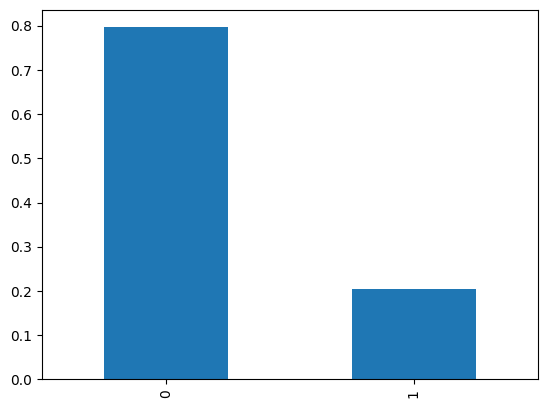

In [7]:
# Contamos la cantidad 1  y 0 para dataframe original
class_frequency = data_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

0    0.796833
1    0.203167
Name: Exited, dtype: float64


<AxesSubplot:>

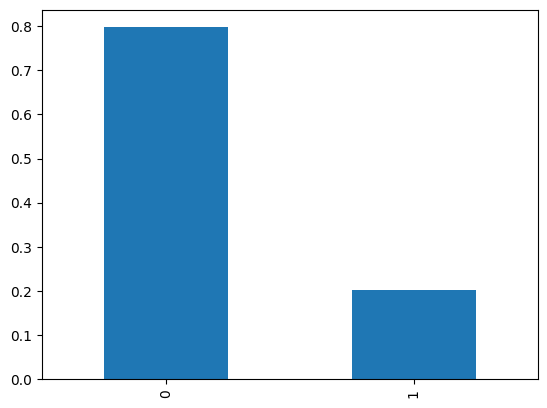

In [8]:
# Contamos la cantidad 1  y 0 para dataframe de entrenamiento
class_frequency_train = target_train.value_counts(normalize=True)
print(class_frequency_train)
class_frequency_train.plot(kind='bar')

0    0.8045
1    0.1955
Name: Exited, dtype: float64


<AxesSubplot:>

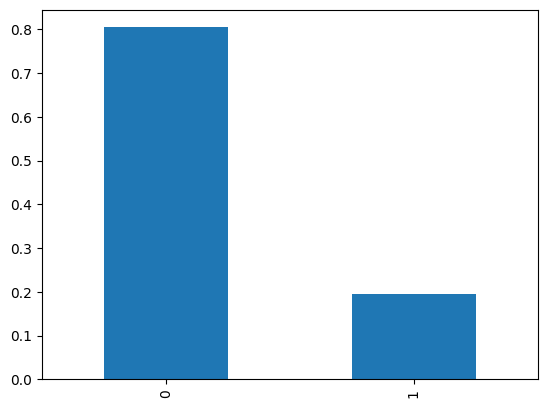

In [9]:
# Contamos la cantidad 1  y 0 para dataframe de validacion
class_frequency_valid = target_valid.value_counts(normalize=True)
print(class_frequency_valid)
class_frequency_valid.plot(kind='bar')

0    0.7865
1    0.2135
Name: Exited, dtype: float64


<AxesSubplot:>

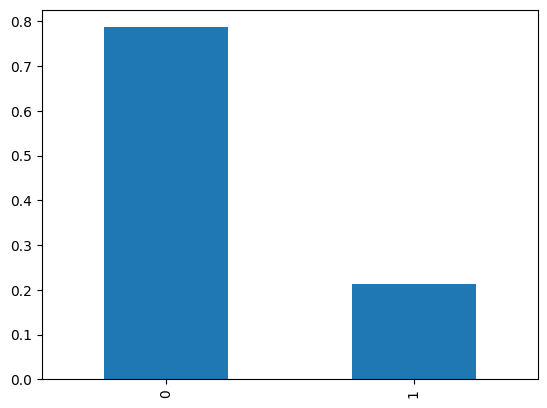

In [10]:
# Contamos la cantidad 1  y 0 para dataframe de prueba
class_frequency_test = target_test.value_counts(normalize=True)
print(class_frequency_test)
class_frequency_test.plot(kind='bar')

En este dataframe tenemos 14 columnas con 10000 registros, tenemos 909 registros vacios en la 'Tenure', no tiene registros duplicados y los tipos de datos son los correcto.

Para el los valores ausentes los rellene con la mediana para no sesgar la data

Se crearon variables dummies y se realizo el escalado de las variables 

Dividir el dataframe en 60% entrenamiento, 20% validacion y 20% prueba 

Se realizo un análisis de que tan balanceados estan los datos que tenemos, en el dataframe original hay 79.63% de ceros y 20.37% de unos 

Para el dataframe de entrenamiento hay 79.68% de ceros y 20.31% de unos 


# Entrenamiento del modelo sin tener en cuenta el desequilibrio

In [11]:
# Modelo de arbol de decisiones
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train,target_train)
predictions_tree = model_tree.predict(features_valid)
predictions_tree_test = model_tree.predict(features_test)
print('F1 validacion :',f1_score(target_valid, predictions_tree))
print('F1 prueba :',f1_score(target_test,predictions_tree_test))

F1 validacion : 0.4944375772558715
F1 prueba : 0.4861751152073733


In [12]:
# Modelo de bosque aleatorio 
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train,target_train)
predictions_forest = model_forest.predict(features_valid)
predictions_forest_test = model_forest.predict(features_test)
print('F1 validacion :',f1_score(target_valid, predictions_forest))
print('F1 prueba :',f1_score(target_test,predictions_forest_test))

F1 validacion : 0.5419354838709678
F1 prueba : 0.5797950219619326


In [13]:
# Modelo de regresion lineal
model_reg = LogisticRegression(random_state=12345, solver='liblinear')
model_reg.fit(features_train,target_train)
predictions_reg = model_reg.predict(features_valid)
predictions_reg_test = model_reg.predict(features_test)
print('F1 del modelo de regresión logística en el conjunto de validación :',f1_score(target_valid,predictions_reg))
print('F1 del modelo de regresión logística en el conjunto de prueba :',f1_score(target_test,predictions_reg_test))

F1 del modelo de regresión logística en el conjunto de validación : 0.2751937984496124
F1 del modelo de regresión logística en el conjunto de prueba : 0.2568807339449541


Una vez realizado los modelos, el mejor es un bosque aleatorio con un F1 de 0.5797

# Mejora la calidad del modelo

In [14]:
# Generar una matriz de confusión
print(confusion_matrix(target_valid,predictions_forest))
print(confusion_matrix(target_test,predictions_forest_test))

[[1548   61]
 [ 223  168]]
[[1515   58]
 [ 229  198]]


In [15]:
# Aplico un sobremuestreo
# Calculando las veces que se debe de multiplicar las carcteristicas con valor de 1 para ser balanceada
ones = data_ohe['Exited'][data_ohe['Exited'] == 1].count()
zeros = data_ohe['Exited'][data_ohe['Exited'] == 0].count()
repeat = zeros/ones
#  Esta función multiplica la caracteristica rara para balanceo de clases
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    repeat_int = int(zeros/ones)
    # Parte fraccionaria de repeat
    repeat_frac = repeat - repeat_int
    arg1 = pd.concat([features_zeros] + [features_ones] * repeat_int)
    arg2 = pd.concat([target_zeros] + [target_ones] * repeat_int)
    # Sobremuestreo con la parte fraccionaria
    if repeat_frac > 0:
        frac_sample = features_ones.sample(frac=repeat_frac, random_state=12345)
        frac_target = target_ones.sample(frac=repeat_frac, random_state=12345)
        upsampled_features = pd.concat([arg1, frac_sample])
        upsampled_target = pd.concat([arg2, frac_target])
        
    features_upsampled, target_upsampled = shuffle(upsampled_features, upsampled_target, random_state=12345)
  
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

print(features_upsampled.shape)
print(target_upsampled.shape)

# Distribución de la variable objetivo
class_distribution = target_upsampled.value_counts()
print(class_distribution)

(9546, 11)
(9546,)
0    4781
1    4765
Name: Exited, dtype: int64


In [18]:
# Modelo de arbol de decisiones
best_f1 = 0
best_depth = 0
best_min_samples_split = 0

for depth in range(1, 30):
    for min_samples_split in range(2, 30):
        model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=min_samples_split)
        model_tree.fit(features_upsampled, target_upsampled)
        predictions_valid = model_tree.predict(features_valid)
        f1_tree = f1_score(target_valid, predictions_valid)
        if f1_tree > best_f1:
            best_f1 = f1_tree
            best_depth = depth
            best_min_samples_split = min_samples_split

print(f"Mejor f1 en validación: {best_f1} con max_depth={best_depth} y min_samples_split={best_min_samples_split}")

Mejor f1 en validación: 0.5622317596566523 con max_depth=8 y min_samples_split=12


In [19]:
# Modelo de bosque aleatorio
best_f1 = 0
best_depth = 0
best_n_estimators = 0
best_min_samples_split = 0
for depth in range(1, 11):
    for n_estimators in range(50, 100, 10): 
        for min_samples_split in range(2, 11):
            model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_estimators, min_samples_split = min_samples_split)
            model_forest.fit(features_upsampled, target_upsampled)
            predictions_valid = model_forest.predict(features_valid)
            f1 = f1_score(target_valid, predictions_valid)
            if f1 > best_f1:
                best_f1 = f1
                best_depth = depth
                best_n_estimators = n_estimators
                best_min_samples_split = min_samples_split

print(f"Mejor f1 en validación: {best_f1} con max_depth={best_depth}, con min_sample_split={best_min_samples_split} y n_estimators={best_n_estimators}")

Mejor f1 en validación: 0.6040268456375838 con max_depth=10, con min_sample_split=4 y n_estimators=80


In [21]:
# Modelo de regresion lineal
# Definir la búsqueda en cuadrícula de parámetros
param_grid = {'C': [0.01, 0.1, 1, 10, 100],'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']}
model_logisticReg = LogisticRegression(random_state=12345, max_iter=10000)
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model_logisticReg, param_grid=param_grid, cv=5, scoring='accuracy')
# Ejecutar la búsqueda en cuadrícula
grid_search.fit(features_upsampled, target_upsampled)
# Obtener los mejores parámetros y la mejor exactitud
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(f"Mejores parámetros: {best_params}")
print(f"Mejor exactitud en validación (con CV): {best_accuracy}")

Mejores parámetros: {'C': 100, 'solver': 'liblinear'}
Mejor exactitud en validación (con CV): 0.701864741003623


Una vez realizo los modelos con la data equilibrada tenemos como resultado que el mejor modelo es un bosque aleatorio con f1=0.6040268456375838, max_depth=10, min_sample_split=4 y n_estimators=80

# Entrenamiento final

In [23]:
# Modelo de  bosque aleatorio con los mejores hiper parametros
model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=10, min_samples_split=4, n_estimators=80)
model_RandomForest.fit(features_upsampled, target_upsampled)
predicted_test = model_RandomForest.predict(features_test)
f1 = f1_score(target_test, predicted_test)
print(f'F1 Score: {f1:.2f}')
y_pred_proba = model_RandomForest.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')
accuracy = accuracy_score(target_test, predicted_test)
print(f'Accuracy: {accuracy}')

F1 Score: 0.64
AUC-ROC: 0.867432120785325
Accuracy: 0.833


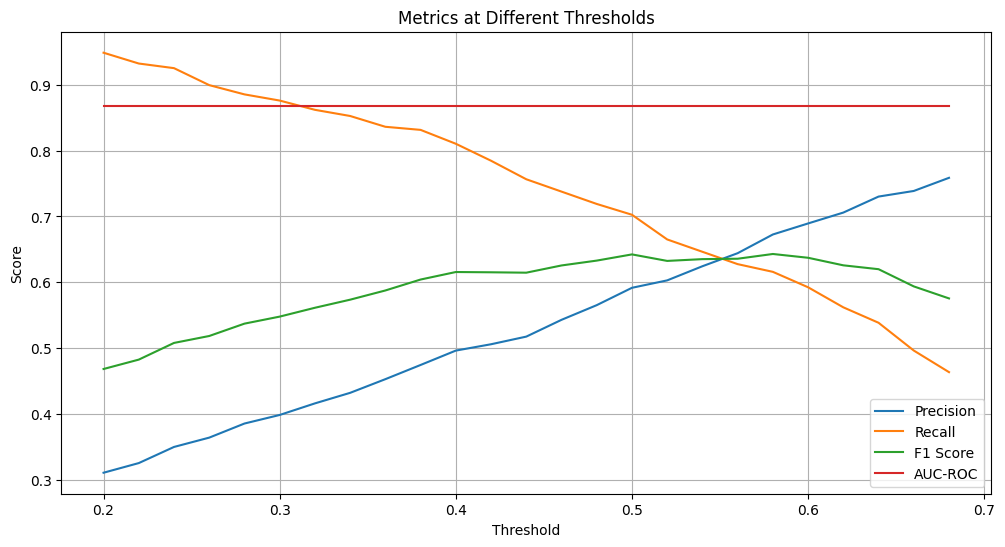

In [29]:
# Observemos el ajuste del umbral
probabilities_test = model_RandomForest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# Listas para almacenar las métricas en función del umbral
thresholds = np.arange(0.2, 0.7, 0.02)
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

for threshold in thresholds:
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, auc_roc_scores, label='AUC-ROC')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

Se rellenaron los valores ausentes y se ajustaron los tipos de datos en algunas columnas.

Se eliminaron columnas sin utilidad para el modelo como 'RowNumber', 'CustomerId' y 'Surname'.

Se crearon variables dummies para los valores de las columnas categóricas y se escalaron las columnas numéricas para preparar los datos para los modelos.

Se dividió el conjunto de datos en subconjuntos de entrenamiento, validacion y prueba.

Se realizon los modelos sin considerar el desbalanceo y nos arrojo que el mejor modelo es un bosque aleatorio con f1=0.5419354838709678

Se crearon conjuntos de datos balanceados mediante sobremuestreo y ajuste de pesos de clase 

Se realizon los modelos nuevamente con la data balanceada nos arrojo que el mejor modelo es un bosque aleatorio con f1=0.6040268456375838, max_depth=10, min_sample_split=4 y n_estimators=80

Threshold = 0.54 | Precision = 0.579, Recall = 0.639, F1 = 0.608, AUC-ROC = 0.853
Evaluación en conjunto de prueba: El modelo mencionado se evaluó en el conjunto de prueba con resultados aún mejores:

F1 Score: 0.63
AUC-ROC: 0.864
Accuracy: 0.829
Ajuste de umbral: Se ajustó el umbral del modelo, superando el F1 requerido de 0.59:

Threshold = 0.52 | Precision = 0.615, Recall = 0.674, F1 = 0.644, AUC-ROC: 0.864
En resumen, el proyecto ha cumplido con éxito el objetivo de desarrollar un modelo predictivo robusto para identificar la posible salida de clientes, superando los criterios establecidos.

